In [1]:
#Standard python imports
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt

#Stats imports
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
import statsmodels.stats.multicomp as mc
import scipy.stats as stats

#random seed for replicability
np.random.seed(seed=42)

In [2]:
den_df = pd.read_csv('../data/dia_df_cleaned.csv')
den_df.head(2)

,severity,start_lat,start_lng,end_lat,end_lng,distance(mi),temperature(f),wind_chill(f),humidity(%),pressure(in),...,hour_20,hour_21,hour_22,hour_23,weather_condition_Light Freezing Rain,weather_condition_Light Snow and Sleet,weather_condition_Freezing Rain,weather_condition_Light Rain Showers,weather_condition_Light Ice Pellets,is_DST
0,4,38.89700,-104.74707,38.89705,-104.747869,0.043,37.9,32.7,18.0,29.94,...,0,0,0,0,0,0,0,0,0,0
1,3,39.62951,-104.90471,39.63764,-104.909150,0.609,37.9,30.5,19.0,29.94,...,0,0,0,0,0,0,0,0,0,0


## ANOVA on severity of accidents for Spring DST Time Change

Equivalent Research Hypotheses were used as those used for the initial Chicago analysis to test the impact of the spring time change and fall time change. For further explanation please reference notebook 5_hypothesis_test_chicago.

In [3]:
#I (CH) referenced this article for a refresher on ANOVA and to find the libraries to use for each test
#https://www.pythonfordatascience.org/anova-python/#anova-test
#I referenced these pages for a refresher on ANOVA vs. Kruskall-Wallace and the impact of a non-normal distribution
# https://stats.stackexchange.com/questions/76059/difference-between-anova-and-kruskal-wallis-test
# http://www.biostathandbook.com/kruskalwallis.html

In [4]:
#Overall comparison of week before, week of DST, and week after DST for traffic accidents in chicago
stats.f_oneway(den_df['severity'][den_df['week'] == 10],
              den_df['severity'][den_df['week'] == 11],
              den_df['severity'][den_df['week'] == 12])

F_onewayResult(statistic=16.175838540279305, pvalue=1.2123064471768523e-07)

In [5]:
den_df_spring_dst =  den_df[(den_df['week'] == 10) | (den_df['week'] == 11) | (den_df['week'] == 12)]
den_df_spring_dst['week'].value_counts()

11    467
12    341
10    219
Name: week, dtype: int64

In [6]:
den_spring_anova = ols("severity ~C(week)", data=den_df_spring_dst).fit()
den_aov_table = sm.stats.anova_lm(den_spring_anova, typ=2)
den_aov_table

,sum_sq,df,F,PR(>F)
C(week),20.111199,2.0,16.175839,1.212306e-07
Residual,636.562608,1024.0,NaN,NaN


In [7]:
#Shapiro test of normality, failed as the severity of accidents is not normally distributed
stats.shapiro(den_spring_anova.resid)

ShapiroResult(statistic=0.9192718863487244, pvalue=5.442149436728024e-23)

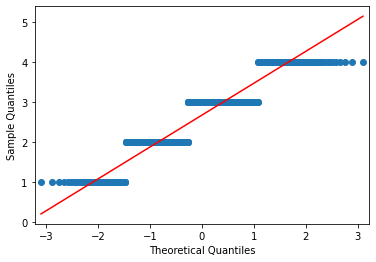

In [8]:
#QQ plot to conform lack of normality
sm.qqplot(den_df_spring_dst['severity'], line='s');

In [9]:
#Levene's test of homogeneity of variance
stats.levene(den_df['severity'][den_df['week'] == 10],
              den_df['severity'][den_df['week'] == 11],
              den_df['severity'][den_df['week'] == 12])

LeveneResult(statistic=28.202339303625628, pvalue=1.1948468045977898e-12)

In [10]:
stats.kruskal(den_df['severity'][den_df['week'] == 10],
              den_df['severity'][den_df['week'] == 11],
              den_df['severity'][den_df['week'] == 12])

KruskalResult(statistic=32.781142848151035, pvalue=7.614918775262036e-08)

### Interpretation
* Given the significant results (KW <0.0001 ANOVA <0.0001 are both smaller than a = 0.05) we can reject our null hypothesis and state that there is evidence of a significant difference in accident severity between the weeks before, during, and after the spring time change. 

## Multiple Comparison Tests

### Tukey Honestly Significant Difference (HSD) Test

In [11]:
den_df_spring_dst['week'] = den_df_spring_dst.week.map({10 : 'Week Before', 11 : 'Week of DST', 12: 'Week After'})
den_df_spring_dst['week'].value_counts()

<ipython-input-11-19ac2ccfb405>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  den_df_spring_dst['week'] = den_df_spring_dst.week.map({10 : 'Week Before', 11 : 'Week of DST', 12: 'Week After'})


Week of DST    467
Week After     341
Week Before    219
Name: week, dtype: int64

In [12]:
comp = mc.MultiComparison(den_df_spring_dst['severity'], den_df_spring_dst['week'], 
                         group_order=['Week Before', 'Week of DST', 'Week After'])
post_hoc = comp.tukeyhsd()
post_hoc.summary()

group1,group2,meandiff,p-adj,lower,upper,reject
Week Before,Week of DST,-0.3478,0.001,-0.4993,-0.1962,True
Week Before,Week After,-0.3323,0.001,-0.4926,-0.172,True
Week of DST,Week After,0.0155,0.9,-0.1163,0.1473,False


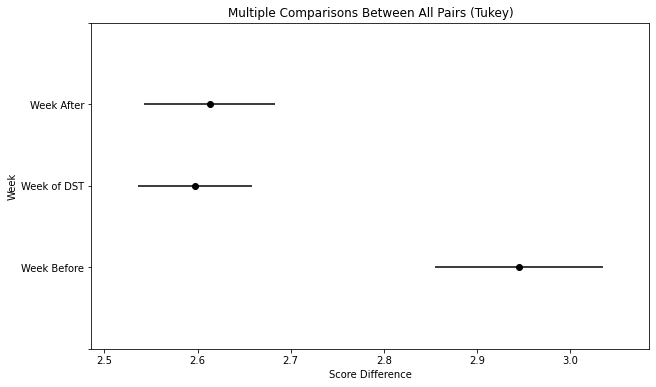

In [13]:
post_hoc.plot_simultaneous(ylabel='Week', xlabel='Score Difference');

### Bonferroni Correction

In [14]:
tbl, a1, a2 = comp.allpairtest(stats.ttest_ind, method='bonf')
tbl

group1,group2,stat,pval,pval_corr,reject
Week Before,Week of DST,5.5974,0.0,0.0,True
Week Before,Week After,5.0973,0.0,0.0,True
Week of DST,Week After,-0.2599,0.795,1.0,False


### Sidak Correction 

In [15]:
tbl, a1, a2 = comp.allpairtest(stats.ttest_ind, method='sidak')
tbl

group1,group2,stat,pval,pval_corr,reject
Week Before,Week of DST,5.5974,0.0,0.0,True
Week Before,Week After,5.0973,0.0,0.0,True
Week of DST,Week After,-0.2599,0.795,0.9914,False


### Interpretation

The results of the above multiple comparison results suggest that differences found by the ANOVA and Kruskall-Wallis occur as follows:
* The week before DSt and the week of DST, with a higher severity the week before
* The week before DST and the week after DST, with a higher severity the week before

These results run counter to our initial supposition that DST leads to an increase in severity.

## ANOVA on severity of accidents for Fall DST Time Change

In [16]:
den_df_fall_dst =  den_df[(den_df['week'] == 44) | (den_df['week'] == 45) | (den_df['week'] == 46)]
den_df_fall_dst['week'].value_counts()

45    399
44    343
46    305
Name: week, dtype: int64

In [17]:
stats.f_oneway(den_df['severity'][den_df['week'] == 44],
              den_df['severity'][den_df['week'] == 45],
              den_df['severity'][den_df['week'] == 46])

F_onewayResult(statistic=2.1213440648394606, pvalue=0.12038681450249894)

In [18]:
stats.kruskal(den_df['severity'][den_df['week'] == 44],
              den_df['severity'][den_df['week'] == 45],
              den_df['severity'][den_df['week'] == 46])

KruskalResult(statistic=4.8901437636328255, pvalue=0.08671990109367533)

### Interpretation
The above ANOVA and Kruskal-Wallis test results both fail to meet our level of significance for our research hypotheses and as such we are unable to reject the null hypothesis that there is no statistically significant difference between the weeks before, during, and after the fall time change.